<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments <br>
Prediction EnergyUse</font></b>

Ce notebook est la suite du notebook d'exploration des données Deveau_Estelle_1_notebook_exploratoire_022024

# Introduction

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_validate
import time
from scipy.stats import uniform
from sklearn.inspection import permutation_importance
from scipy.stats import uniform, loguniform

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb',
 'Deveau_Estelle_2_notebook_prediction_EnergyUse_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'svg']

In [3]:
os.listdir("data/cleaned/")

['df_cleaned.csv']

In [4]:
path     = "./data/cleaned/"
filename = "df_cleaned.csv"

In [5]:
df = pd.read_csv(path + filename)
df.head()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,...,GFA_Autres,GFA_Education,GFA_Bureaux,GFA_Industrie_entrepots,GFA_Hopital,GFA_Restauration,GFA_Supermarche,GFA_Sciences,Log_TotalGHGEmissions,Log_SiteEnergyUseWN
0,1.0,12,0,60.0,7456910.0,249.98,89,1,26.872820,52.917723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.521381,15.824652
1,1.0,11,15064,61.0,8664479.0,295.86,20,3,0.000000,37.426959,...,0.0,0.0,0.0,0.0,0.0,4622.0,0.0,0.0,5.689886,15.974742
2,1.0,41,196718,43.0,73937112.0,2089.28,47,1,29.168781,66.984851,...,2899.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.644575,18.118725
3,1.0,10,0,56.0,6946800.5,286.43,90,1,31.877211,39.858983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.657494,15.753792
4,1.0,11,0,27.0,6062767.5,176.14,90,1,0.000000,46.368511,...,1656.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.171279,15.617677


In [6]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
# Suppression des individus avec une valeur non nulle dans , 'GFA_Laboratoire_Hopital'
#df = df[df['GFA_Sciences'] == 0]
df = df[df['GFA_Hopital'] == 0]

#Suppression de la colonne GFA_Laboratoire_Hopital
df.drop(columns=['GFA_Hopital'], inplace=True)



In [8]:
df.shape

(1125, 24)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1125 entries, 0 to 1136
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NumberofBuildings         1125 non-null   float64
 1   NumberofFloors            1125 non-null   int64  
 2   PropertyGFAParking        1125 non-null   int64  
 3   ENERGYSTARScore           721 non-null    float64
 4   SiteEnergyUseWN(kBtu)     1125 non-null   float64
 5   TotalGHGEmissions         1125 non-null   float64
 6   BuildingAge               1125 non-null   int64  
 7   NumberOfPropertyUseTypes  1125 non-null   int64  
 8   SteamUse_pct              1125 non-null   float64
 9   Electricity_pct           1125 non-null   float64
 10  NaturalGas_pct            1125 non-null   float64
 11  GFA_Résidences            1125 non-null   float64
 12  GFA_Culture_Loisirs       1125 non-null   float64
 13  GFA_Commerces             1125 non-null   float64
 14  GFA_Services 

In [10]:
df.describe()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Culture_Loisirs,GFA_Commerces,GFA_Services,GFA_Autres,GFA_Education,GFA_Bureaux,GFA_Industrie_entrepots,GFA_Restauration,GFA_Supermarche,GFA_Sciences,Log_TotalGHGEmissions,Log_SiteEnergyUseWN
count,1125.000000,1125.000000,1125.000000,721.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1.125000e+03,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,1.138667,3.858667,6795.221333,62.370319,6.375838e+06,133.083467,57.465778,1.858667,1.803274,65.938005,27.009044,8801.447111,6.725651e+03,13798.491733,1208.751111,7807.110667,7.237583e+03,3.711244e+04,12690.807111,869.228444,1534.199111,964.592889,3.858672,14.847279
std,1.290662,6.134504,28845.931933,28.604830,1.164646e+07,296.175261,31.989126,1.185067,8.172059,26.895396,23.868687,49044.117439,6.216816e+04,47698.080596,17393.649409,36268.938048,6.401996e+04,1.204346e+05,31955.569594,4891.450993,9412.096268,10571.657581,1.461545,1.231309
min,1.000000,1.000000,0.000000,1.000000,5.811420e+04,0.400000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-0.916291,10.970165
25%,1.000000,1.000000,0.000000,43.000000,1.213910e+06,19.140000,33.000000,1.000000,0.000000,44.196752,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.951780,14.009357
50%,1.000000,2.000000,0.000000,69.000000,2.447326e+06,46.440000,54.000000,1.000000,0.000000,64.900075,26.215991,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.838161,14.710506
75%,1.000000,4.000000,0.000000,86.000000,6.211750e+06,127.290000,88.000000,2.000000,0.000000,94.824479,46.790293,0.000000,0.000000e+00,4270.000000,0.000000,1200.000000,0.000000e+00,2.526200e+04,12644.000000,0.000000,0.000000,0.000000,4.846468,15.641953
max,27.000000,76.000000,327680.000000,100.000000,1.371061e+08,3995.450000,116.000000,9.000000,64.773098,100.000000,97.077764,756493.000000,1.585960e+06,561684.000000,537150.000000,535947.000000,1.719643e+06,1.680937e+06,407491.000000,80000.000000,144776.000000,181930.000000,8.292911,18.736266


Dans un premier temps, nous allons travailler en excluant l'ENERGYSTARScore puis nous ferons une comparaison avec son utilisation.

# Modelisation sans l'Energy Star Score

## Importance des features

### Data preparation

On supprime NaturalGas_pct car déductibles des autres features.

In [11]:
# Sélection des variables explicatives et des variables cibles
features = df.drop(['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)', 'Log_TotalGHGEmissions', 'Log_SiteEnergyUseWN', 'ENERGYSTARScore'], axis=1)
target = df['Log_SiteEnergyUseWN']

In [12]:
features.head(1)

,NumberofBuildings,NumberofFloors,PropertyGFAParking,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Culture_Loisirs,GFA_Commerces,GFA_Services,GFA_Autres,GFA_Education,GFA_Bureaux,GFA_Industrie_entrepots,GFA_Restauration,GFA_Supermarche,GFA_Sciences
0,1.0,12,0,89,1,26.87282,52.917723,17.11772,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Séparation des données

In [13]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Conservez les noms des colonnes dans une variable avant la mise à l'échelle
column_names = X_train.columns

# Affichage des dimensions des ensembles d'entraînement et de test
X_train.shape, X_test.shape

((900, 19), (225, 19))

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 578 to 869
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NumberofBuildings         900 non-null    float64
 1   NumberofFloors            900 non-null    int64  
 2   PropertyGFAParking        900 non-null    int64  
 3   BuildingAge               900 non-null    int64  
 4   NumberOfPropertyUseTypes  900 non-null    int64  
 5   SteamUse_pct              900 non-null    float64
 6   Electricity_pct           900 non-null    float64
 7   NaturalGas_pct            900 non-null    float64
 8   GFA_Résidences            900 non-null    float64
 9   GFA_Culture_Loisirs       900 non-null    float64
 10  GFA_Commerces             900 non-null    float64
 11  GFA_Services              900 non-null    float64
 12  GFA_Autres                900 non-null    float64
 13  GFA_Education             900 non-null    float64
 14  GFA_Bureaux  

In [15]:
X_train.head()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Culture_Loisirs,GFA_Commerces,GFA_Services,GFA_Autres,GFA_Education,GFA_Bureaux,GFA_Industrie_entrepots,GFA_Restauration,GFA_Supermarche,GFA_Sciences
578,1.0,3,0,106,2,0.0,28.904128,59.248131,0.0,31917.0,0.0,0.0,0.0,0.0,41632.0,0.0,0.0,0.0,0.0
884,1.0,3,0,106,2,0.0,99.999957,0.000000,0.0,0.0,10057.0,0.0,6602.0,0.0,32393.0,0.0,0.0,0.0,0.0
720,1.0,2,0,95,1,0.0,99.999993,0.000000,0.0,0.0,0.0,0.0,41022.0,0.0,0.0,0.0,0.0,0.0,0.0
561,1.0,1,0,44,1,0.0,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48112.0,0.0,0.0,0.0
696,1.0,4,10849,33,1,0.0,99.999971,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,24008.0,0.0,0.0,0.0,0.0


In [16]:
y_train.head()

578    14.981521
884    14.181157
720    15.147256
561    14.196656
696    14.067683
Name: Log_SiteEnergyUseWN, dtype: float64

### Standardisation

In [17]:
# Initialisation du StandardScaler
scaler = StandardScaler()

In [18]:
# Normalisation des ensembles d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Affichage des premières lignes des données normalisées pour vérification
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=column_names)
X_train_scaled_df.head(5)

,NumberofBuildings,NumberofFloors,PropertyGFAParking,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Culture_Loisirs,GFA_Commerces,GFA_Services,GFA_Autres,GFA_Education,GFA_Bureaux,GFA_Industrie_entrepots,GFA_Restauration,GFA_Supermarche,GFA_Sciences
578,-0.11065,-0.126004,-0.243215,1.515009,0.106708,-0.205957,-1.371829,1.349665,-0.170182,0.352735,-0.311448,-0.065277,-0.207675,-0.100671,0.051917,-0.412075,-0.186178,-0.161073,-0.08648
884,-0.11065,-0.126004,-0.243215,1.515009,0.106708,-0.205957,1.260279,-1.137671,-0.170182,-0.109507,-0.076660,-0.065277,-0.029394,-0.100671,-0.030566,-0.412075,-0.186178,-0.161073,-0.08648
720,-0.11065,-0.299669,-0.243215,1.173099,-0.721198,-0.205957,1.260280,-1.137671,-0.170182,-0.109507,-0.311448,-0.065277,0.900087,-0.100671,-0.319763,-0.412075,-0.186178,-0.161073,-0.08648
561,-0.11065,-0.473334,-0.243215,-0.412123,-0.721198,-0.205957,1.260281,-1.137671,-0.170182,-0.109507,-0.311448,-0.065277,-0.207675,-0.100671,-0.319763,1.200138,-0.186178,-0.161073,-0.08648
696,-0.11065,0.047661,0.151986,-0.754034,-0.721198,-0.205957,1.260280,-1.137671,-0.170182,-0.109507,-0.311448,-0.065277,-0.207675,-0.100671,-0.105426,-0.412075,-0.186178,-0.161073,-0.08648


### Test de Student

In [19]:
# Ajout d'une constante à X pour le terme d'interception
X_train_const = sm.add_constant(X_train_scaled_df)

# Ajuster le modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Obtenir et afficher le résumé du modèle
summary = model.summary()
print(summary)

                             OLS Regression Results                            
Dep. Variable:     Log_SiteEnergyUseWN   R-squared:                       0.579
Model:                             OLS   Adj. R-squared:                  0.570
Method:                  Least Squares   F-statistic:                     63.72
Date:                 Sun, 25 Feb 2024   Prob (F-statistic):          1.17e-150
Time:                         15:06:21   Log-Likelihood:                -1071.9
No. Observations:                  900   AIC:                             2184.
Df Residuals:                      880   BIC:                             2280.
Df Model:                           19                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

In [20]:
# Suppression du NumberofFloors
X_train_scaled_df.drop(columns=['NumberOfPropertyUseTypes'], inplace=True)

In [21]:
# Ajout d'une constante à X pour le terme d'interception
X_train_const = sm.add_constant(X_train_scaled_df)

# Ajuster le modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Obtenir et afficher le résumé du modèle
summary = model.summary()
print(summary)

                             OLS Regression Results                            
Dep. Variable:     Log_SiteEnergyUseWN   R-squared:                       0.577
Model:                             OLS   Adj. R-squared:                  0.569
Method:                  Least Squares   F-statistic:                     66.83
Date:                 Sun, 25 Feb 2024   Prob (F-statistic):          9.41e-151
Time:                         15:06:21   Log-Likelihood:                -1073.9
No. Observations:                  900   AIC:                             2186.
Df Residuals:                      881   BIC:                             2277.
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

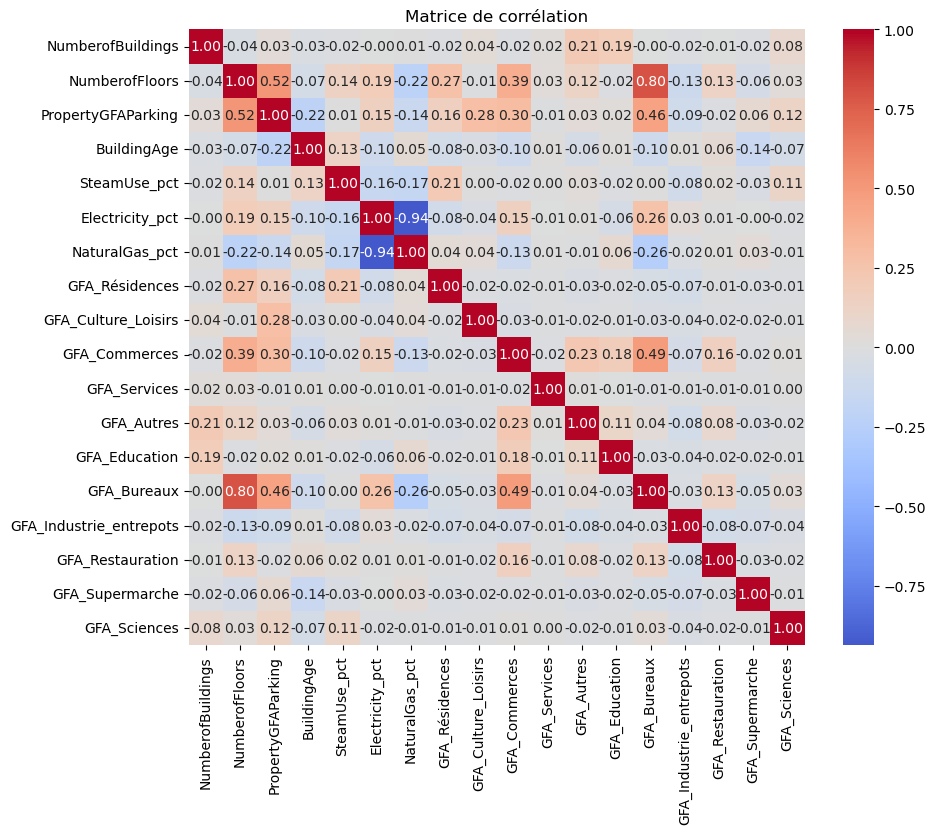

In [22]:
# Calcul de la matrice de corrélation
corr_matrix = X_train_scaled_df.corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, center=0)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()

## Tests de modèles

### Data preparation

In [23]:
# Sélection des variables explicatives et des variables cibles
features = df.drop(['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)', 'Log_TotalGHGEmissions', 'Log_SiteEnergyUseWN', 'ENERGYSTARScore', 
                    'NumberOfPropertyUseTypes'], axis=1)
# , 'NumberofFloors'
target = df['Log_SiteEnergyUseWN']

# Transformation des variables catégorielles en variables numériques (encodage one-hot)
features = pd.get_dummies(features)

In [24]:
features.head(1)

,NumberofBuildings,NumberofFloors,PropertyGFAParking,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Culture_Loisirs,GFA_Commerces,GFA_Services,GFA_Autres,GFA_Education,GFA_Bureaux,GFA_Industrie_entrepots,GFA_Restauration,GFA_Supermarche,GFA_Sciences
0,1.0,12,0,89,26.87282,52.917723,17.11772,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Conservez les noms des colonnes dans une variable avant la mise à l'échelle
column_names = X_train.columns

# Affichage des dimensions des ensembles d'entraînement et de test
X_train.shape, X_test.shape

((900, 18), (225, 18))

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 578 to 869
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NumberofBuildings        900 non-null    float64
 1   NumberofFloors           900 non-null    int64  
 2   PropertyGFAParking       900 non-null    int64  
 3   BuildingAge              900 non-null    int64  
 4   SteamUse_pct             900 non-null    float64
 5   Electricity_pct          900 non-null    float64
 6   NaturalGas_pct           900 non-null    float64
 7   GFA_Résidences           900 non-null    float64
 8   GFA_Culture_Loisirs      900 non-null    float64
 9   GFA_Commerces            900 non-null    float64
 10  GFA_Services             900 non-null    float64
 11  GFA_Autres               900 non-null    float64
 12  GFA_Education            900 non-null    float64
 13  GFA_Bureaux              900 non-null    float64
 14  GFA_Industrie_entrepots  900 

In [27]:
X_train.head()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Culture_Loisirs,GFA_Commerces,GFA_Services,GFA_Autres,GFA_Education,GFA_Bureaux,GFA_Industrie_entrepots,GFA_Restauration,GFA_Supermarche,GFA_Sciences
578,1.0,3,0,106,0.0,28.904128,59.248131,0.0,31917.0,0.0,0.0,0.0,0.0,41632.0,0.0,0.0,0.0,0.0
884,1.0,3,0,106,0.0,99.999957,0.000000,0.0,0.0,10057.0,0.0,6602.0,0.0,32393.0,0.0,0.0,0.0,0.0
720,1.0,2,0,95,0.0,99.999993,0.000000,0.0,0.0,0.0,0.0,41022.0,0.0,0.0,0.0,0.0,0.0,0.0
561,1.0,1,0,44,0.0,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48112.0,0.0,0.0,0.0
696,1.0,4,10849,33,0.0,99.999971,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,24008.0,0.0,0.0,0.0,0.0


### Standardisation

In [28]:
# Initialisation du StandardScaler
scaler = StandardScaler()

In [29]:
# Normalisation des ensembles d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Affichage des premières lignes des données normalisées pour vérification
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=column_names)
X_train_scaled_df.head(5)

,NumberofBuildings,NumberofFloors,PropertyGFAParking,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Culture_Loisirs,GFA_Commerces,GFA_Services,GFA_Autres,GFA_Education,GFA_Bureaux,GFA_Industrie_entrepots,GFA_Restauration,GFA_Supermarche,GFA_Sciences
578,-0.11065,-0.126004,-0.243215,1.515009,-0.205957,-1.371829,1.349665,-0.170182,0.352735,-0.311448,-0.065277,-0.207675,-0.100671,0.051917,-0.412075,-0.186178,-0.161073,-0.08648
884,-0.11065,-0.126004,-0.243215,1.515009,-0.205957,1.260279,-1.137671,-0.170182,-0.109507,-0.076660,-0.065277,-0.029394,-0.100671,-0.030566,-0.412075,-0.186178,-0.161073,-0.08648
720,-0.11065,-0.299669,-0.243215,1.173099,-0.205957,1.260280,-1.137671,-0.170182,-0.109507,-0.311448,-0.065277,0.900087,-0.100671,-0.319763,-0.412075,-0.186178,-0.161073,-0.08648
561,-0.11065,-0.473334,-0.243215,-0.412123,-0.205957,1.260281,-1.137671,-0.170182,-0.109507,-0.311448,-0.065277,-0.207675,-0.100671,-0.319763,1.200138,-0.186178,-0.161073,-0.08648
696,-0.11065,0.047661,0.151986,-0.754034,-0.205957,1.260280,-1.137671,-0.170182,-0.109507,-0.311448,-0.065277,-0.207675,-0.100671,-0.105426,-0.412075,-0.186178,-0.161073,-0.08648


### Test globale

In [30]:
# Liste de modèles à évaluer
models = [
    ('DummyRegressorMedian', DummyRegressor(strategy='median')),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet(random_state=0)),
    ('RandomForest', RandomForestRegressor(random_state=0)),
    ('GradientBoostingReg', GradientBoostingRegressor(random_state=0)),
    ('XGBoostReg', XGBRegressor(random_state=0)),
    ('SVR', SVR()),
    ('AdaBoostReg', AdaBoostRegressor(random_state=0))
]

# Tableau pour collecter les résultats
results = []

# Évaluer chaque modèle
for name, model in models:
    # Entraîner le modèle
    start_time = time.time() 
    model.fit(X_train_scaled, y_train)
    end_time = time.time()  # Enregistre le temps de fin
    duration = end_time - start_time  # Calcule la durée
    
    # Prédire sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)
    
    # Calculer les métriques
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # RMSE CV
    scores_rmse = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_cv = np.sqrt(-scores_rmse).mean()
    
    # R2 CV
    scores_r2 = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    r2_cv = scores_r2.mean()
    r2_cv_std = scores_r2.std() 
    
    results.append((name, rmse, mae, r2, rmse_cv, r2_cv, r2_cv_std, duration))


In [31]:
# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results, columns=['Modèle', 'RMSE', 'MAE', 'R2', 'RMSE CV', 'R2 CV', 'R2 CV Std', 'Temps de calcul'])
df_sorted_by_performance = df_results.sort_values(by=['R2 CV'], ascending=[False])

df_sorted_by_performance

,Modèle,RMSE,MAE,R2,RMSE CV,R2 CV,R2 CV Std,Temps de calcul
8,SVR,0.639008,0.471119,0.734659,0.677005,0.693126,0.026263,0.033053
5,RandomForest,0.668159,0.491839,0.709897,0.703390,0.668721,0.024061,0.723954
6,GradientBoostingReg,0.689276,0.516074,0.691270,0.705812,0.666353,0.026305,0.190888
7,XGBoostReg,0.690119,0.520183,0.690514,0.713485,0.658560,0.033676,0.295819
1,LinearRegression,0.890018,0.628397,0.485258,0.847740,0.518675,0.055727,0.000503
2,Ridge,0.885912,0.628937,0.489996,0.849012,0.517358,0.055154,0.000000
9,AdaBoostReg,0.921659,0.695798,0.448008,0.925611,0.427960,0.043262,0.083068
4,ElasticNet,1.218457,0.966261,0.035256,1.209393,0.023678,0.005601,0.001000
3,Lasso,1.246006,0.984353,-0.008863,1.227672,-0.006153,0.006327,0.001005
0,DummyRegressorMedian,1.266270,0.989310,-0.041944,1.235881,-0.020408,0.023484,0.000000


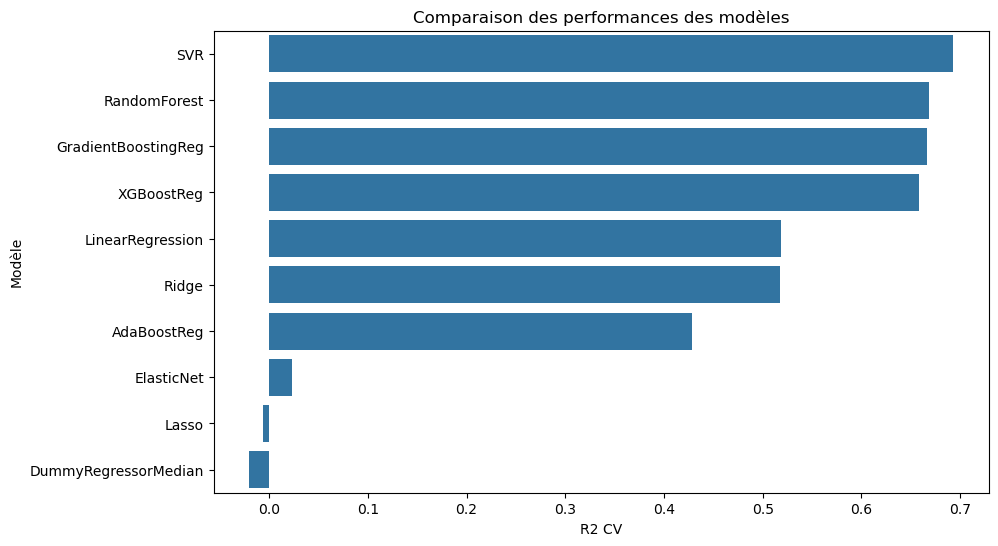

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x='R2 CV', y='Modèle', data=df_sorted_by_performance)
plt.title('Comparaison des performances des modèles')
plt.show()

Les modèles Ridge, Lasso, LinearRegression sont les 3 meilleurs modèles avec des performances assez similaires. Nous allons etudier chacun d'eux pour voir lequel sera le meilleur une fois les hyperparamètres trouvés.

## Regression Ridge

## Linear Regression

## Random Forest

## SVR

### Le modèle de base

In [33]:
# Créer le modèle SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Entraîner le modèle sur les données d'entraînement mises à l'échelle
svr_model.fit(X_train_scaled, y_train)

# Prédire sur l'ensemble de test mis à l'échelle
y_pred_svr = svr_model.predict(X_test_scaled)

# Calculer les métriques pour le modèle SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
smape_svr = 100 * np.mean(2 * np.abs(y_pred_svr - y_test) / (np.abs(y_pred_svr) + np.abs(y_test)))

print("Métriques pour le modèle SVR :")
print("RMSE: {:.2f}".format(rmse_svr))
print("MAE: {:.2f}".format(mae_svr))
print("R2: {:.2f}".format(r2_svr))
print("SMAPE: {:.2f}%".format(smape_svr))

Métriques pour le modèle SVR :
RMSE: 0.64
MAE: 0.47
R2: 0.73
SMAPE: 3.20%


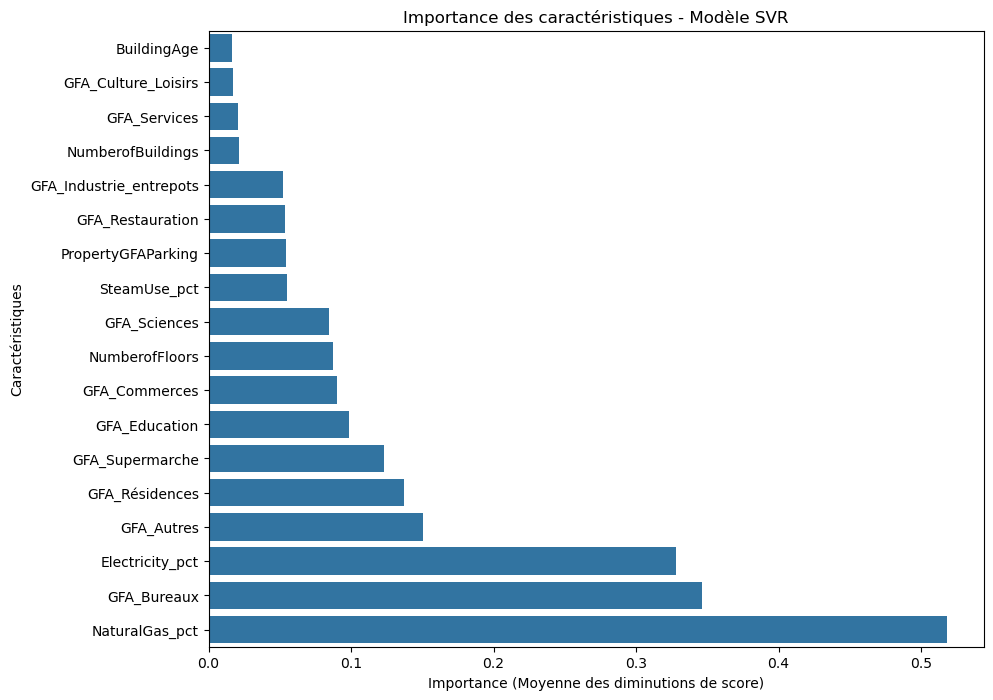

In [34]:
# Calculer l'importance des caractéristiques par permutation
perm_importance = permutation_importance(svr_model, X_test_scaled, y_test, n_repeats=30, random_state=0)

# Créer un DataFrame pour stocker les features et leur importance
features_svr = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm_importance.importances_mean})

# Tri des caractéristiques par importance décroissante
features_svr = features_svr.sort_values('Importance', ascending=True)

# Création du graphique
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=features_svr)
plt.title('Importance des caractéristiques - Modèle SVR')
plt.xlabel('Importance (Moyenne des diminutions de score)')
plt.ylabel('Caractéristiques')
plt.show()

### Recherche des hyperparamètres

In [35]:
# Définition de l'espace des hyperparamètres pour RandomizedSearchCV
param_distributions = {
    'C': loguniform(1e-3, 1e3), 
    'epsilon': uniform(0.01, 1), 
    'gamma': loguniform(1e-4, 1e-1) 
}

# Création de l'objet RandomizedSearchCV pour une SVR
random_search_svr = RandomizedSearchCV(estimator=SVR(kernel='rbf'), 
                                        param_distributions=param_distributions,
                                        n_iter=100,  
                                        scoring='neg_mean_squared_error',  
                                        cv=5,  
                                        random_state=0, 
                                        verbose=1)  

# Exécution de la recherche aléatoire
random_search_svr.fit(X_train_scaled, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs hyperparamètres (RandomizedSearchCV) pour SVR: ", random_search_svr.best_params_)
meilleur_score_rmse_svr = np.sqrt(-random_search_svr.best_score_) 
print("Meilleur score (RMSE) pour SVR: ", meilleur_score_rmse_svr)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Meilleurs hyperparamètres (RandomizedSearchCV) pour SVR:  {'C': 8.177482436211173, 'epsilon': 0.44141843543397397, 'gamma': 0.04893727555349513}
Meilleur score (RMSE) pour SVR:  0.6452867535764969


In [36]:
# Définition de la grille d'hyperparamètres à explorer
param_grid_svr = {
    'C': np.linspace(start=max(0.1, 4.935798091294871 - 1), stop=4.935798091294871 + 1, num=10),
    'epsilon': np.linspace(start=max(0.01, 0.13381998284944152 - 0.05), stop=0.13381998284944152 + 0.05, num=10),
    'gamma': np.linspace(start=max(1e-5, 0.0349965060627184 - 0.01), stop=0.0349965060627184 + 0.01, num=10)
}

# Création de l'objet GridSearchCV pour une SVR
grid_search_svr = GridSearchCV(estimator=SVR(kernel='rbf'), 
                               param_grid=param_grid_svr, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               n_jobs=-1, 
                               verbose=1)

# Exécution de la recherche par grille sur l'ensemble d'entraînement
grid_search_svr.fit(X_train_scaled, y_train)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour SVR: ", grid_search_svr.best_params_)

# Calcul de la RMSE sur l'ensemble de test avec le meilleur modèle trouvé
y_pred_gs_svr = grid_search_svr.best_estimator_.predict(X_test_scaled)
rmse_gs_svr = np.sqrt(mean_squared_error(y_test, y_pred_gs_svr))
mae_gs_svr = mean_absolute_error(y_test, y_pred_gs_svr)
r2_gs_svr = r2_score(y_test, y_pred_gs_svr)
smape_svr = 100 * np.mean(2 * np.abs(y_pred_gs_svr - y_test) / (np.abs(y_pred_gs_svr) + np.abs(y_test)))

print("RMSE avec GridSearchCV pour SVR: {:.4f}".format(rmse_gs_svr))
print("MAE avec GridSearchCV pour SVR: {:.4f}".format(mae_gs_svr))
print("R2 avec GridSearchCV pour SVR: {:.4f}".format(r2_gs_svr))
print("SMAPE avec GridSearchCV pour SVR: {:.4f}%".format(smape_svr))


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Meilleurs hyperparamètres pour SVR:  {'C': 5.935798091294871, 'epsilon': 0.1838199828494415, 'gamma': 0.0449965060627184}
RMSE avec GridSearchCV pour SVR: 0.6426
MAE avec GridSearchCV pour SVR: 0.4627
R2 avec GridSearchCV pour SVR: 0.7317
SMAPE avec GridSearchCV pour SVR: 3.1359%


In [37]:
# Meilleurs hyperparamètres obtenus de GridSearchCV pour SVR
best_params_svr = grid_search_svr.best_params_

# Configuration du modèle SVR avec les meilleurs hyperparamètres
best_svr_model = SVR(**best_params_svr)

# Métriques à évaluer lors de la validation croisée
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

# Exécution de la validation croisée (5 plis)
cv_results_svr = cross_validate(best_svr_model, X_train_scaled, y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Calcul et affichage des métriques moyennes pour chaque pli
rmse_scores_svr = np.sqrt(-cv_results_svr['test_neg_mean_squared_error'])
mae_scores_svr = -cv_results_svr['test_neg_mean_absolute_error']
r2_scores_svr = cv_results_svr['test_r2']

# Affichage avec écart type
print(f"Validation Croisée RMSE pour SVR: {rmse_scores_svr.mean():.4f} (± {rmse_scores_svr.std():.4f})")
print(f"Validation Croisée MAE pour SVR: {mae_scores_svr.mean():.4f} (± {mae_scores_svr.std():.4f})")
print(f"Validation Croisée R² pour SVR: {r2_scores_svr.mean():.4f} (± {r2_scores_svr.std():.4f})")

Validation Croisée RMSE pour SVR: 0.6442 (± 0.0249)
Validation Croisée MAE pour SVR: 0.4859 (± 0.0126)
Validation Croisée R² pour SVR: 0.7217 (± 0.0269)


In [38]:
best_svr_model.fit(X_train_scaled, y_train) 

# Prédictions sur l'ensemble d'entraînement
y_train_pred = best_svr_model.predict(X_train_scaled)

# Prédictions sur l'ensemble de test
y_test_pred = best_svr_model.predict(X_test_scaled)

# Calcul des métriques pour l'ensemble d'entraînement
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_smape = 100 * np.mean(2 * np.abs(y_train_pred - y_train) / (np.abs(y_train_pred) + np.abs(y_train)))

# Calcul des métriques pour l'ensemble de test
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_smape = 100 * np.mean(2 * np.abs(y_test_pred - y_test) / (np.abs(y_test_pred) + np.abs(y_test)))

# Affichage des métriques
print("Ensemble d'entraînement : RMSE = {:.2f}, R² = {:.2f}, MAE = {:.2f}, SMAPE = {:.2f}%".format(train_rmse, train_r2, train_mae, train_smape))
print("Ensemble de test : RMSE = {:.2f}, R² = {:.2f}, MAE = {:.2f}, SMAPE = {:.2f}%".format(test_rmse, test_r2, test_mae, test_smape))


Ensemble d'entraînement : RMSE = 0.54, R² = 0.81, MAE = 0.39, SMAPE = 2.69%
Ensemble de test : RMSE = 0.64, R² = 0.73, MAE = 0.46, SMAPE = 3.14%


## Analyse des erreurs

### Avec les cibles en log

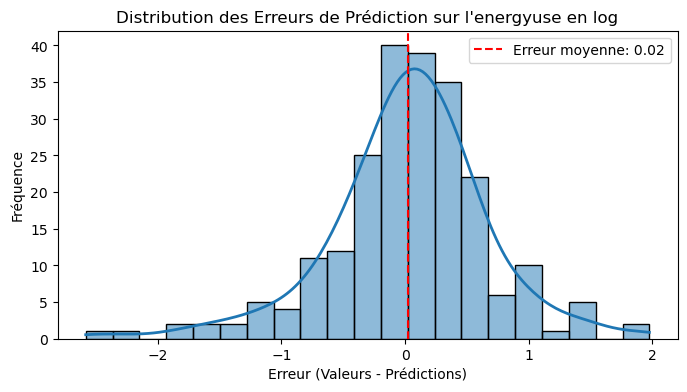

In [39]:
# Calcul des erreurs
errors = y_test - y_test_pred

# Calcul de l'erreur moyenne
mean_error = np.mean(errors)

# Visualisation de la distribution des erreurs
# Couleurs de la palette tab10
colors_tab10 = plt.cm.tab10(np.arange(10))
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True, color=colors_tab10[0], line_kws={'color': colors_tab10[1], 'linewidth': 2})
plt.axvline(mean_error, color='red', linestyle='--', label=f'Erreur moyenne: {mean_error:.2f}')
plt.title('Distribution des Erreurs de Prédiction sur l\'energyuse en log')
plt.xlabel('Erreur (Valeurs - Prédictions)')
plt.ylabel('Fréquence')
plt.legend()

plt.show()

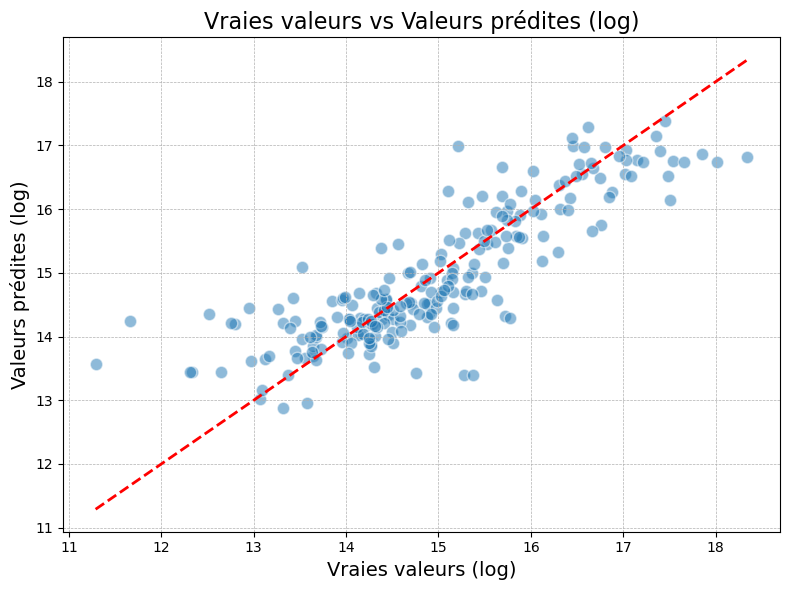

In [40]:
plt.figure(figsize=(8, 6))  # Augmenter la taille du graphique
plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolors='w', s=80)  # Ajouter des bords blancs pour mieux distinguer les points superposés
plt.title('Vraies valeurs vs Valeurs prédites (log)', fontsize=16)
plt.xlabel('Vraies valeurs (log)', fontsize=14)
plt.ylabel('Valeurs prédites (log)', fontsize=14)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, linestyle='--')  # Ligne y=x
plt.grid(True, which='major', linestyle='--', linewidth=0.5)  # Grille plus fine
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7)  # Grille mineure
plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour bien remplir la figure
plt.show()


### Avec les valeurs réelles

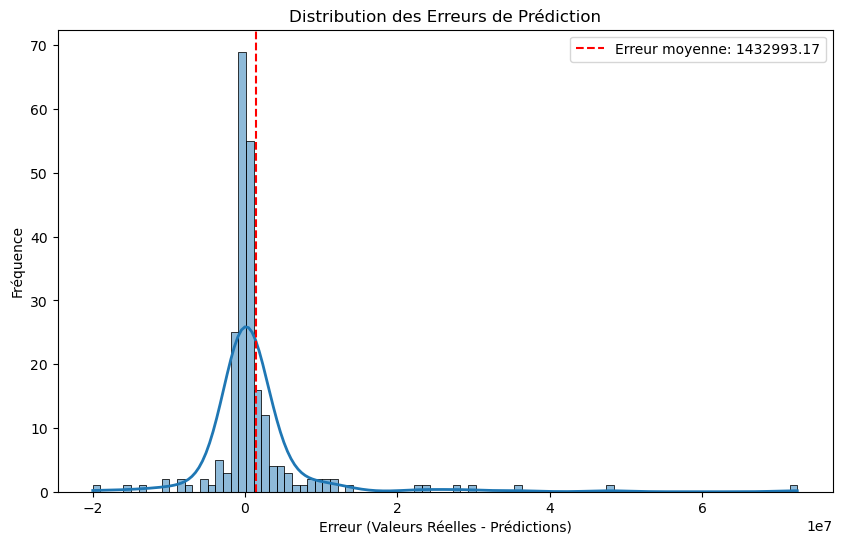

In [41]:
# Conversion des prédictions et des valeurs réelles de test de log à l'échelle originale
y_test_pred_original = np.exp(y_test_pred) 
y_test_original = np.exp(y_test)  

# Calcul des erreurs
errors = y_test_original - y_test_pred_original

# Calcul de l'erreur moyenne
mean_error = np.mean(errors)

# Visualisation de la distribution des erreurs
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color=colors_tab10[0], binwidth=1000000, line_kws={'color': colors_tab10[1], 'linewidth': 2})
plt.axvline(mean_error, color='red', linestyle='--', label=f'Erreur moyenne: {mean_error:.2f}')
plt.title('Distribution des Erreurs de Prédiction')
plt.xlabel('Erreur (Valeurs Réelles - Prédictions)')
plt.ylabel('Fréquence')
plt.legend()

plt.show()

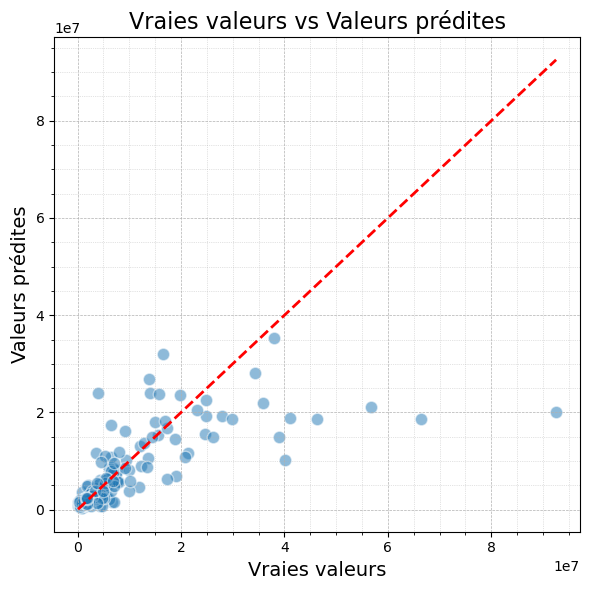

In [42]:
plt.figure(figsize=(6, 6)) 
plt.scatter(y_test_original, y_test_pred_original, alpha=0.5, edgecolors='w', s=80)  
plt.title('Vraies valeurs vs Valeurs prédites', fontsize=16)
plt.xlabel('Vraies valeurs', fontsize=14)
plt.ylabel('Valeurs prédites', fontsize=14)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', lw=2, linestyle='--')  # Ligne y=x
plt.grid(True, which='major', linestyle='--', linewidth=0.5) 
plt.minorticks_on() 
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7) 
plt.tight_layout() 
plt.show()

In [43]:
# Création d'un DataFrame avec les valeurs réelles et prédites
df_errors = pd.DataFrame({'Valeurs réelles': y_test_original, 'Valeurs prédites': y_test_pred_original})


# Calcul des erreurs absolues et ajout en tant que nouvelle colonne
df_errors['Erreurs absolues'] = abs(df_errors['Valeurs réelles'] - df_errors['Valeurs prédites'])

# Trier le DataFrame par les erreurs absolues de façon décroissante
df_errors_sorted = df_errors.sort_values('Erreurs absolues', ascending=False)

# Afficher les 15 erreurs les plus grandes
print(df_errors_sorted.head(15))

      Valeurs réelles  Valeurs prédites  Erreurs absolues
339        92537256.0      2.004350e+07      7.249376e+07
90         66502836.0      1.866588e+07      4.783696e+07
296        56785916.0      2.103468e+07      3.575124e+07
110        40037736.0      1.017082e+07      2.986692e+07
342        46343304.0      1.866216e+07      2.768114e+07
1109       38977108.0      1.486500e+07      2.411211e+07
56         41151732.0      1.876923e+07      2.238250e+07
205         4021869.0      2.401064e+07      1.998877e+07
39         16527711.0      3.206778e+07      1.554007e+07
333        35938164.0      2.197940e+07      1.395876e+07
131        13862720.0      2.695163e+07      1.308891e+07
384        19009360.0      6.884797e+06      1.212456e+07
139        29949248.0      1.872083e+07      1.122842e+07
103        26122018.0      1.501231e+07      1.110970e+07
297        17254810.0      6.271686e+06      1.098312e+07


In [44]:
indices_plus_gd_erreurs = df_errors_sorted.head(15).index
df_top_errors = df.loc[indices_plus_gd_erreurs]
df_top_errors

,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Culture_Loisirs,GFA_Commerces,GFA_Services,GFA_Autres,GFA_Education,GFA_Bureaux,GFA_Industrie_entrepots,GFA_Restauration,GFA_Supermarche,GFA_Sciences,Log_TotalGHGEmissions,Log_SiteEnergyUseWN
339,1.0,76,319400,86.0,92537256.0,882.56,31,2,0.000000,94.527767,5.472233,0.0,0.0,319368.0,0.0,0.0,0.0,1680937.0,0.0,0.0,0.0,0.0,6.782827,18.343122
90,1.0,7,0,NaN,66502836.0,1638.46,17,5,0.000000,59.191632,38.619649,495536.0,0.0,438756.0,0.0,0.0,0.0,0.0,0.0,49700.0,0.0,0.0,7.401512,18.012755
296,1.0,42,0,97.0,56785916.0,481.06,11,5,1.737056,97.073232,0.684205,0.0,0.0,348788.0,0.0,25384.0,0.0,1218742.0,0.0,0.0,0.0,0.0,6.175992,17.854799
110,1.0,10,0,93.0,40037736.0,398.19,91,2,0.052994,93.595531,6.351475,0.0,0.0,361107.0,0.0,0.0,0.0,332343.0,0.0,0.0,0.0,0.0,5.986929,17.505333
342,1.0,2,0,NaN,46343304.0,324.25,17,4,0.000000,100.000000,0.000000,0.0,100000.0,561684.0,0.0,206303.0,0.0,0.0,0.0,80000.0,0.0,0.0,5.781515,17.651587
1109,1.0,3,0,NaN,38977108.0,1280.81,91,1,34.779951,56.265380,3.939084,0.0,0.0,0.0,0.0,0.0,472384.0,0.0,0.0,0.0,0.0,0.0,7.155248,17.478485
56,27.0,2,0,NaN,41151732.0,866.23,46,1,0.000000,61.515212,31.559221,0.0,0.0,0.0,0.0,0.0,483000.0,0.0,0.0,0.0,0.0,0.0,6.764150,17.532777
205,1.0,1,0,NaN,4021869.0,121.98,61,2,0.000000,36.572176,52.305458,0.0,0.0,0.0,91532.0,0.0,0.0,22248.0,0.0,0.0,0.0,0.0,4.803857,15.207257
39,1.0,3,0,48.0,16527711.0,430.84,51,1,0.000000,59.196767,40.803233,0.0,0.0,0.0,0.0,0.0,0.0,179014.0,0.0,0.0,0.0,0.0,6.065737,16.620549
333,1.0,4,18382,NaN,35938164.0,1154.79,17,1,0.000000,46.418392,53.581608,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,97365.0,7.051674,17.397310


# Modélisation avec l'Energy Star Score

# Comparaison et conclusion